In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from Energy.Models.Model1 import model1
from Energy.Models.Model2 import model2

# import importlib
# importlib.reload(Energy.Models)

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


If needed: Fetch energy-data first

In [2]:
# from Energy.HelpFunctions.get_energy_data import fetch_energy_data
# fetch_energy_data()

In [3]:
df = get_energy_data()
df = prepare_data(df)

# Cross validate baseline model

Remove everything til last thursday night 12pm

In [4]:
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

Repeatedly run the model. Record predictions and true values (observations). Make sure the observations are available for the most recent prediction.

In [5]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)        
        
        pred = None     
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models(model['function'][0], model['function'][1], df_before)
               
        
        obs = pd.DataFrame({'gesamt': df.loc[pred['forecast_date']]["gesamt"]})
        pred = pred.set_index('forecast_date')
        merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    
         # Add scores to the merged_df
        for index, row in merged_df.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['gesamt']
            score = evaluate_horizon(quantile_preds, observation)
            merged_df.at[index, 'score'] = score
        # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
        evaluation = pd.concat([evaluation, merged_df])
    return evaluation

## Evaluation of selected Models

In [6]:
from Energy.Models.Model4 import model4
from Energy.Models.Model3 import model3

models = [
    # {
    #     'name': 'MM_baseline_model3',
    #     'function': [[baseline, model1],[0.5,0.5]]
    # },
    {
        'name': 'baseline',
        'function': baseline
     },
    # {
    #     'name': 'model1',
    #     'function': model1
    # },
    # {
    #     'name': 'model2',
    #     'function': model2
    # },
    {
        'name': 'model4',
        'function': model4
    },
    {
        'name': 'model3',
        'function': model3
    },
    
    
]

start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

In [7]:
evaluate_models(models, df_cval, last_x=100, weeks=True)

*********** Start the evaluation of Model baseline ***********
Iteration 0 of 100
Iteration 1 of 100
Iteration 2 of 100
Iteration 3 of 100
Iteration 4 of 100
Iteration 5 of 100
Iteration 6 of 100
Iteration 7 of 100
Iteration 8 of 100
Iteration 9 of 100
Iteration 10 of 100
Iteration 11 of 100
Iteration 12 of 100
Iteration 13 of 100
Iteration 14 of 100
Iteration 15 of 100
Iteration 16 of 100
Iteration 17 of 100
Iteration 18 of 100
Iteration 19 of 100
Iteration 20 of 100
Iteration 21 of 100
Iteration 22 of 100
Iteration 23 of 100
Iteration 24 of 100
Iteration 25 of 100
Iteration 26 of 100
Iteration 27 of 100
Iteration 28 of 100
Iteration 29 of 100
Iteration 30 of 100
Iteration 31 of 100
Iteration 32 of 100
Iteration 33 of 100
Iteration 34 of 100
Iteration 35 of 100
Iteration 36 of 100
Iteration 37 of 100
Iteration 38 of 100
Iteration 39 of 100
Iteration 40 of 100
Iteration 41 of 100
Iteration 42 of 100
Iteration 43 of 100
Iteration 44 of 100
Iteration 45 of 100
Iteration 46 of 100
Iterati

### Save evaluations in pkl file

In [8]:
with open('./Model evaluations/bl_m3_MM-bl-m3.pkl', 'wb') as f:
    pickle.dump(models, f)

# with open('model_evaluations.pkl', 'rb') as f:
#     models = pickle.load(f)

### Create a table that only contains the different scores of the different models

In [9]:
# scores = [m['evaluation']['score'][m['evaluation']['horizon'] == '36 hour'] for m in models]
# horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
# 
# 
# names = [m['name'] for m in models]
# score_df = pd.concat(scores, axis=1,keys=names)

In [10]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)

        

In [11]:
score_df

,baseline: 36 hour,model4: 36 hour,model3: 36 hour,baseline: 40 hour,model4: 40 hour,model3: 40 hour,baseline: 44 hour,model4: 44 hour,model3: 44 hour,baseline: 60 hour,model4: 60 hour,model3: 60 hour,baseline: 64 hour,model4: 64 hour,model3: 64 hour,baseline: 68 hour,model4: 68 hour,model3: 68 hour
forecast_date,,,,,,,,,,,,,,,,,,
2021-12-24 12:00:00,20.324298,20.845379,25.479228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-24 16:00:00,NaN,NaN,NaN,9.378204,18.974566,29.517978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-24 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,23.253081,28.777451,29.961177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-25 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.682117,21.160455,20.757989,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-25 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.366639,20.732890,14.071739,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 16:00:00,NaN,NaN,NaN,8.409935,8.147032,11.786313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-17 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7.431993,6.221533,5.945220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-18 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.939070,6.663545,6.512190,NaN,NaN,NaN,NaN,NaN,NaN


### Plot the densities of the obtained scores

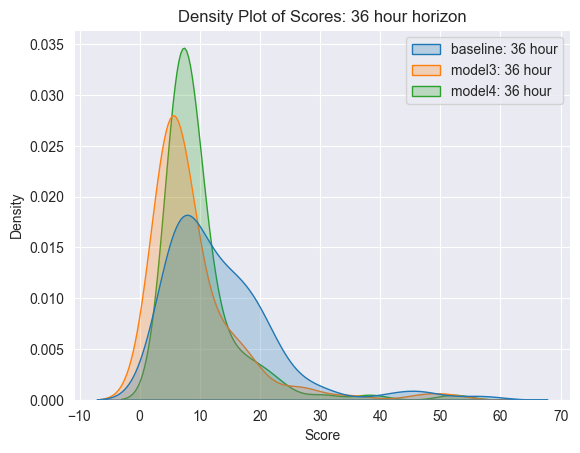

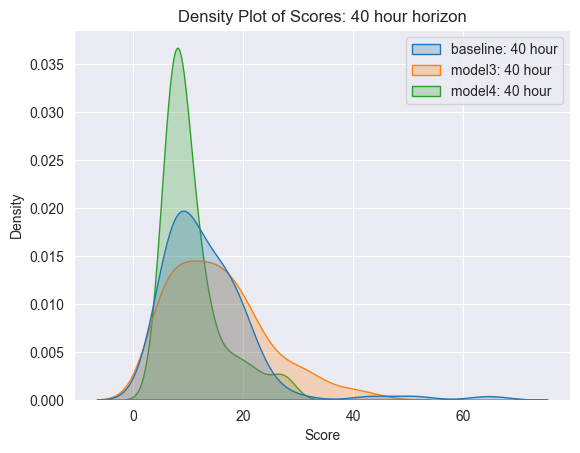

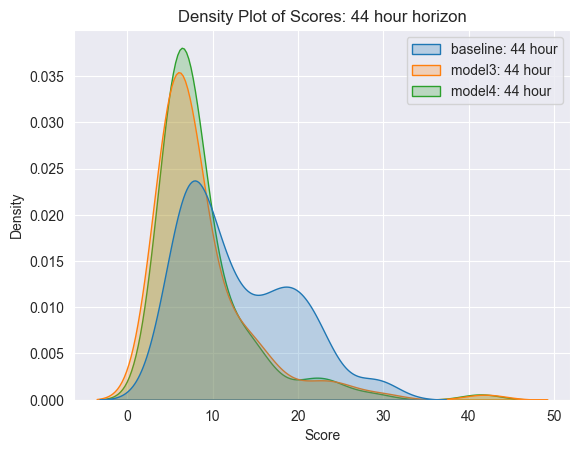

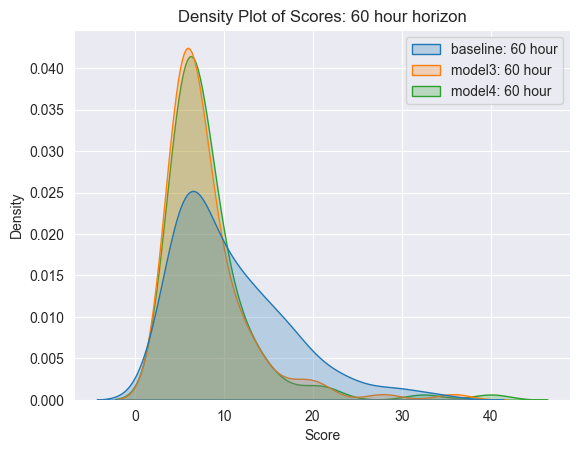

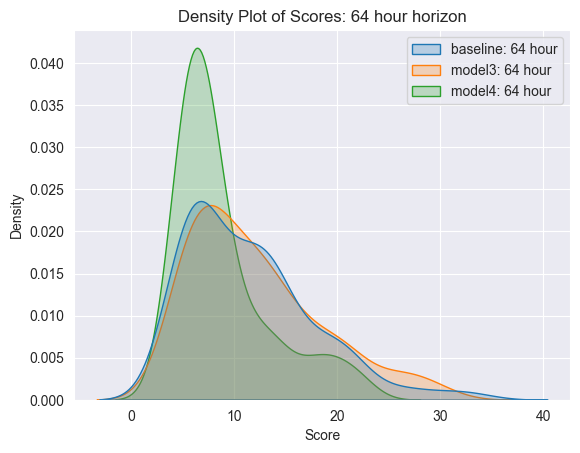

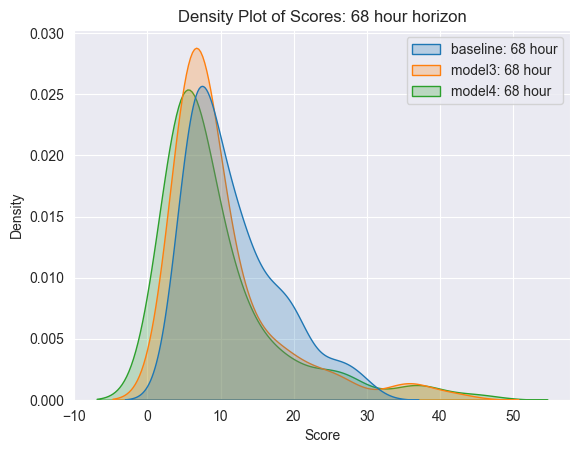

In [25]:
models_display = ['baseline','model3','model4']
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    # sns.kdeplot(data=score_df.loc[:,[f'baseline: {h}',f'model3: {h}',f'MM_baseline_model3: {h}']], fill=True)
    sns.kdeplot(data=score_df.loc[:,[f'{m}: {h}' for m in models_display]], fill=True)
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')
    
    # Display the plot
    plt.savefig(f'plots/density_plot_{h.replace(" ", "_")}.png')
    plt.show()

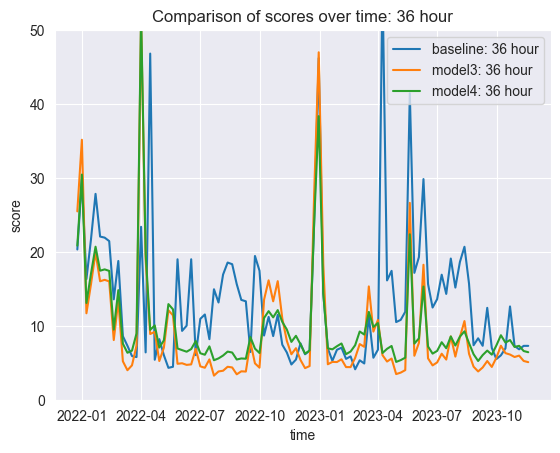

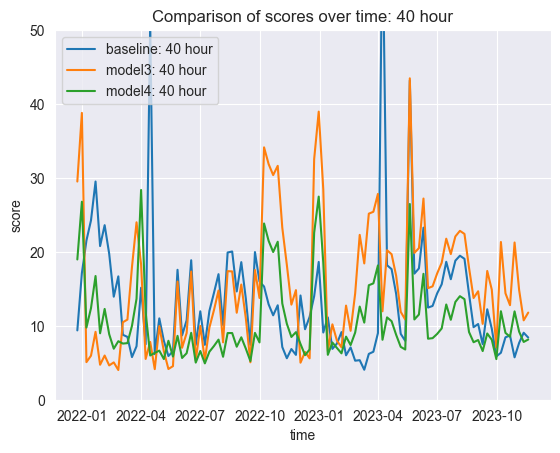

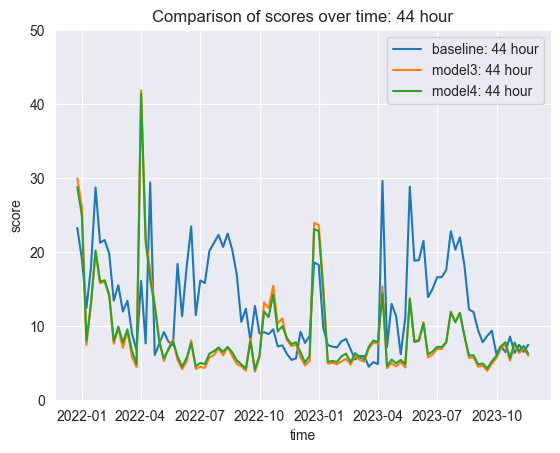

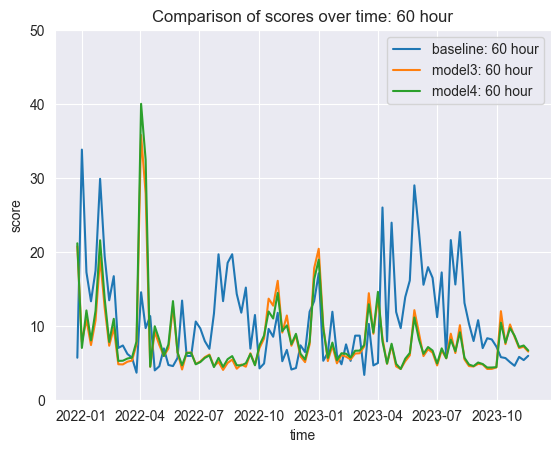

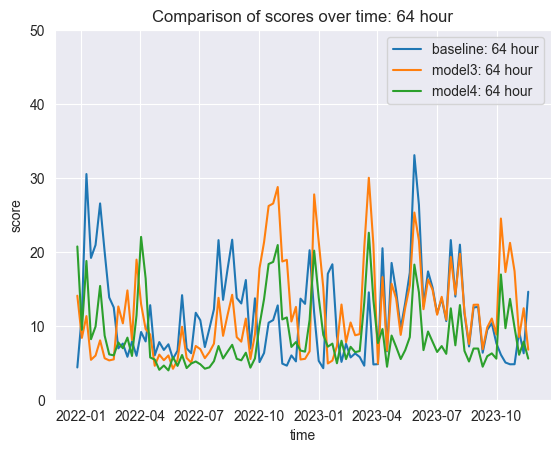

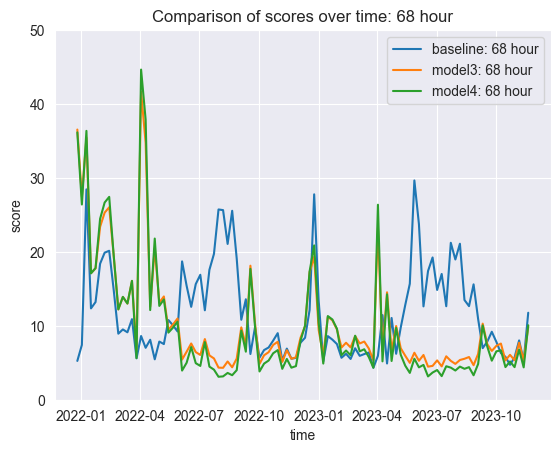

In [13]:
models_display = ['baseline','model3','model4']
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    # Plot values from two columns over time
    score_df_36_no_na = score_df[score_df[f'{models_display[0]}: {h}'].notna()]
    for c in [f'{m}: {h}' for m in models_display]:
        # plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
        # plt.plot(score_df_36_no_na.index, score_df_36_no_na['model1: 36 hour'], label='model1')
        # plt.plot(score_df_36_no_na.index, score_df_36_no_na['model2: 36 hour'], label='model2')
        plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label=c)
        # plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label='model4')
        # Adding labels and title
    plt.xlabel('time')
    plt.ylabel('score')
    plt.title(f'Comparison of scores over time: {h}')
    plt.ylim(0,50)
    
    # Display legend
    plt.legend()

    # Show the plot
    plt.show()

In [14]:
# mix_models([baseline2, model3], [1,1],df_cval)

In [15]:
# # from HelpFunctions.mix_models import mix_models as mm
# # 
# # import importlib
# # importlib.reload(Energy.Models)
# 
# 
# from importlib import reload
# from HelpFunctions import mix_models as mms
# reload(mms)
# 
# mms.mix_models_per_horizon([baseline, model3, baseline], [[ 1,1,0,0,0,0], [0,0,1,1,0,0], [0,0,0,0,1,1]], df)

In [16]:
models_display = ['baseline']
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    for c in [f'{m}: {h}' for m in models_display]:
        df_sorted = score_df[c].sort_values().dropna().tail(10)
        
        
        print(f'{c}')
        print(df_sorted)

baseline: 36 hour
forecast_date
2022-01-28 12:00:00    22.072968
2022-04-01 12:00:00    23.392792
2022-12-23 12:00:00    23.977391
2022-01-21 12:00:00    27.849271
2021-12-31 12:00:00    29.794923
2023-06-09 12:00:00    29.847516
2023-05-19 12:00:00    41.452174
2022-12-30 12:00:00    46.208209
2022-04-15 12:00:00    46.825597
2023-04-07 12:00:00    56.576709
Name: baseline: 36 hour, dtype: float64
baseline: 40 hour
forecast_date
2022-08-19 16:00:00    20.054224
2022-01-28 16:00:00    20.788040
2022-01-07 16:00:00    21.532517
2023-06-09 16:00:00    23.278744
2022-02-04 16:00:00    23.615821
2022-01-14 16:00:00    24.259517
2022-01-21 16:00:00    29.518479
2023-05-19 16:00:00    43.186252
2022-04-15 16:00:00    50.913193
2023-04-07 16:00:00    64.637389
Name: baseline: 40 hour, dtype: float64
baseline: 44 hour
forecast_date
2023-08-04 20:00:00    21.978468
2022-07-29 20:00:00    22.311362
2022-08-12 20:00:00    22.472706
2023-07-21 20:00:00    22.792978
2021-12-24 20:00:00    23.253081

In [17]:
score_df

,baseline: 36 hour,model4: 36 hour,model3: 36 hour,baseline: 40 hour,model4: 40 hour,model3: 40 hour,baseline: 44 hour,model4: 44 hour,model3: 44 hour,baseline: 60 hour,model4: 60 hour,model3: 60 hour,baseline: 64 hour,model4: 64 hour,model3: 64 hour,baseline: 68 hour,model4: 68 hour,model3: 68 hour
forecast_date,,,,,,,,,,,,,,,,,,
2021-12-24 12:00:00,20.324298,20.845379,25.479228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-24 16:00:00,NaN,NaN,NaN,9.378204,18.974566,29.517978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-24 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,23.253081,28.777451,29.961177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-25 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.682117,21.160455,20.757989,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-25 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.366639,20.732890,14.071739,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 16:00:00,NaN,NaN,NaN,8.409935,8.147032,11.786313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-17 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7.431993,6.221533,5.945220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-18 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.939070,6.663545,6.512190,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
from importlib import reload
from Energy.HelpFunctions import dummy_mapping as dm

reload(dm)

dm.get_holiday_dummy(df).loc['2023-04-07 01:00:00',:]

gesamt     41.85575
weekday     4.00000
holiday     1.00000
Name: 2023-04-07 01:00:00, dtype: float64

In [19]:
models[0]['evaluation']

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,gesamt,score
forecast_date,,,,,,,,,
2023-11-17 12:00:00,energy,36 hour,53.274763,60.869062,63.552250,66.894750,74.963481,66.74250,7.287530
2023-11-17 16:00:00,energy,40 hour,50.642019,55.801063,58.491375,62.676437,70.579475,62.46675,8.409935
2023-11-17 20:00:00,energy,44 hour,49.348806,52.409875,56.135375,59.975938,67.135544,58.89500,7.431993
2023-11-18 12:00:00,energy,60 hour,47.477200,51.317125,53.837750,57.222375,63.336100,56.03125,5.939070
2023-11-18 16:00:00,energy,64 hour,44.081156,47.397937,50.045750,53.217188,61.228112,55.77425,14.609598
...,...,...,...,...,...,...,...,...,...
2021-12-24 16:00:00,energy,40 hour,49.422063,58.959750,61.605000,66.756438,72.169269,58.39400,9.378204
2021-12-24 20:00:00,energy,44 hour,49.794556,55.053125,59.819375,63.832500,66.994919,50.64075,23.253081
2021-12-25 12:00:00,energy,60 hour,51.602300,54.199938,55.887000,59.868625,63.945256,54.01875,5.682117


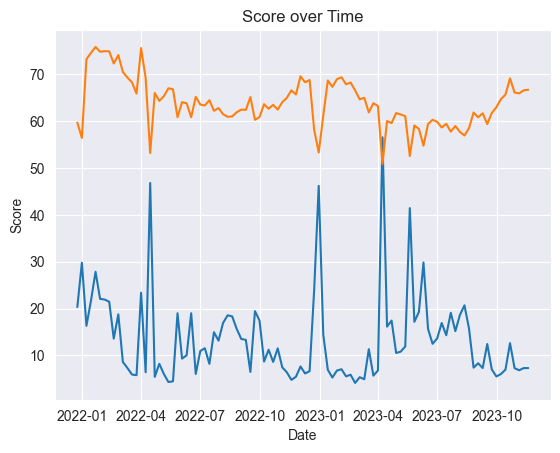

In [20]:
import matplotlib.pyplot as plt

# Assuming models[0] is your DataFrame
df = models[0]['evaluation']
df = df[df['horizon']=='36 hour']

# Convert the "forecast_date" column to datetime if it's not already
# df['forecast_date'] = pd.to_datetime(df['forecast_date'])

# Plotting
plt.plot(df.index, df.loc[:,['score','gesamt']])
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Score over Time')
plt.show()

In [21]:
print(df.columns)

Index(['target', 'horizon', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975',
       'gesamt', 'score'],
      dtype='object')


In [22]:
df

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,gesamt,score
forecast_date,,,,,,,,,
2023-11-17 12:00:00,energy,36 hour,53.274763,60.869062,63.552250,66.894750,74.963481,66.74250,7.287530
2023-11-10 12:00:00,energy,36 hour,53.274763,60.869062,63.552250,67.128563,74.963481,66.62375,7.285686
2023-11-03 12:00:00,energy,36 hour,53.274763,60.869062,63.552250,67.496313,75.325700,65.95400,6.817922
2023-10-27 12:00:00,energy,36 hour,53.274763,60.869062,63.552250,68.005250,75.325700,66.15400,7.272391
2023-10-20 12:00:00,energy,36 hour,53.274763,60.869062,63.552250,68.005250,75.325700,69.16975,12.617141
...,...,...,...,...,...,...,...,...,...
2022-01-21 12:00:00,energy,36 hour,50.738319,63.703250,66.714000,70.733125,74.044744,75.88775,27.849271
2022-01-14 12:00:00,energy,36 hour,50.738319,63.703250,66.714000,70.733125,73.924913,74.61150,21.701692
2022-01-07 12:00:00,energy,36 hour,50.738319,63.703250,66.714000,70.733125,73.924913,73.27550,16.320517
